In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

from utils import *

In [8]:
events = [1.1, 5.2, 7.1, 12.1, 25]

video of length 30s, hop length 0.5 and frame length 0.5

In [10]:
n_hops = 60
start_time = 0
end_time = 30
nn_hop_length_half = 0.25

In [11]:
time = np.linspace(start_time + nn_hop_length_half, end_time - nn_hop_length_half, n_hops)
time

array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,
        4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
        9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
       13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75,
       18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25, 21.75, 22.25,
       22.75, 23.25, 23.75, 24.25, 24.75, 25.25, 25.75, 26.25, 26.75,
       27.25, 27.75, 28.25, 28.75, 29.25, 29.75])

In [12]:
cumstep = get_cumstep(time, events)
cumstep

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5.])

[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


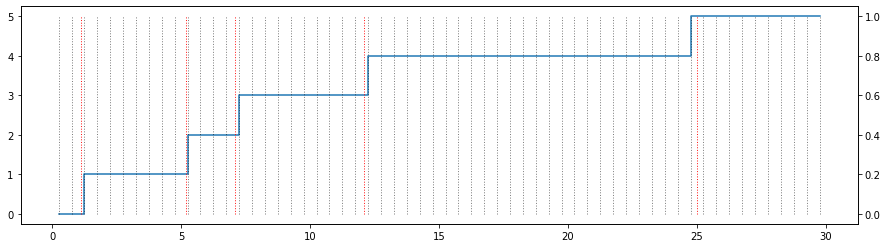

Output()

In [13]:
def create_slider(value=0.0):
    slider = widgets.FloatSlider(
        value=value,
        min=start_time,
        max=end_time,
        step=0.05,
        readout_format='.1f'
    )
    return slider

def show(**kwargs):
    plt.close('all')
    
    events = []
    for i, slider in enumerate(sliders.children):
        events.append(slider.value)
        
    cumstep = get_cumstep(time, events)
        
    fig, ax1 = plt.subplots(figsize=(15, 4))
    ax2 = ax1.twinx()

    for t in time:
        ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
    ax1.step(time, cumstep, where='post');
    print(cumstep)

    for i, event in enumerate(events):
        ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)
        
    plt.show()

sliders = widgets.VBox(
    children=[create_slider(value=e) for e in events], 
    layout=widgets.Layout(flex_flow='row wrap'))

out = widgets.interactive_output(show, {
        f'{slider}': slider for slider in sliders.children
    })

display(sliders, out)

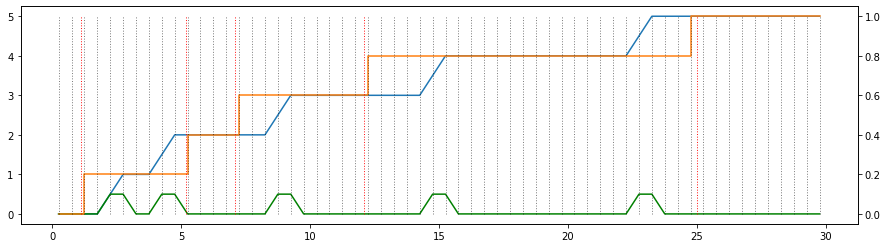

In [94]:
from scipy.stats import norm

def gaussian(x, c=1):
    pdf = norm.pdf(time, loc=x, scale=0.1)
    return pdf / pdf.sum() * c

y = gaussian(2.5) + gaussian(4.5) + gaussian(9) + gaussian(15) + gaussian(23)
# y = gaussian(1.1) + gaussian(5.2) + gaussian(7.1) + gaussian(12.1) + gaussian(25)

cumsum = np.cumsum(y)
cumstep = get_cumstep(time, events)

fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

ax1.plot(time, cumsum);
ax1.plot(time, y, color='green');
ax1.step(time, cumstep, where='post');
# ax1.plot(time, cumstep);

for t in time:
    ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
for i, event in enumerate(events):
    ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)

plt.show()

In [95]:
# obj
np.abs(cumstep - cumsum).sum()

16.5

In [96]:
def discretize(time, events):
    discrete_events = []

    closest = lambda array, value: np.abs(array - value).argmin()

    for e in events:
        idx = closest(time, e)
        discrete_events.append(idx)
    discrete_events

#     discrete_events = [0] + discrete_events
    return discrete_events

discrete_events = discretize(time, events)

In [74]:
discrete_events

[2, 10, 14, 24, 49]

In [97]:
def pairs(array):

    for i in range(len(array)):
        if i < len(array) - 1:
            yield array[i: i + 2]
            
for i, j in pairs(discrete_events):
    print(i, j)

2 10
10 14
14 24
24 49


In [98]:
def dist(t_plus_delta_0, t_plus_delta_1, cumsum, c):
    N = len(cumsum)
    
    if t_plus_delta_0 < 0 or t_plus_delta_0 > N:
        return np.inf
    
    if t_plus_delta_1 < 0 or t_plus_delta_1 > N:
        return np.inf

    if t_plus_delta_1 - t_plus_delta_0 <= 0:
        return np.inf

    return np.abs(cumsum[t_plus_delta_0: t_plus_delta_1] - c).sum()

In [99]:
N = 7
deltas = np.arange(-N, N + 1)

distances = np.zeros((len(deltas), len(discrete_events)))
backtracking = np.zeros_like(distances)

t_1 = discrete_events[0]
t_n = discrete_events[-1]
end = len(cumsum)

for i, delta_1 in enumerate(deltas):
    t_plus_delta_1 = t_1 + delta_1
    d = dist(0, t_plus_delta_1, cumsum, 0)
    distances[i, 0] = d
#     print(f'{delta_1}: {d:.8f}')
    
# print(distances)
# backtracking[:, 0] = distances[:, 0].argmin()
backtracking[:, 0] = np.arange(len(backtracking))
# print(backtracking)

for c, (t_0, t_1) in enumerate(pairs(discrete_events)):
    for j, delta_1 in enumerate(deltas):
        min_d = np.inf
        
        for i, delta_0 in enumerate(deltas):
            t_plus_delta_0 = t_0 + delta_0
            t_plus_delta_1 = t_1 + delta_1
            
            d = dist(t_plus_delta_0, t_plus_delta_1, cumsum, c + 1)
            
            prev_d = distances[i, c]
            next_d = d + prev_d
            
            if next_d < min_d:
                min_d = next_d
                backtracking[j, c + 1] = i
                distances[j, c + 1] = next_d

print(c + 1)
last = c + 2
print(last)

distances
print(t_n)
print(end)
for i, delta_0 in enumerate(deltas):
    t_plus_delta_0 = t_n + delta_0
    prev_d = distances[i, -1]
#     print(t_plus_delta_0)
#     t_plus_delta_0 = prev_d + delta_0
    d = dist(t_plus_delta_0, end, cumsum, last)
#     print(d)
#     print(prev_d)
#     print(i)
#     print(prev_d + d )
#     print()
    distances[i, -1] = prev_d + d 
#     print(f'{delta_1}: {d:.8f}')
    
print(distances)

backtrack_from = np.argmin(distances[:, -1])

4
5
49
60
[[ inf  1.   1.5  2.   5.5]
 [ inf  1.   1.5  1.5  4.5]
 [ inf  0.5  1.   1.5  3.5]
 [ inf  0.5  1.   1.5  2.5]
 [ inf  0.5  1.   1.5  2.5]
 [ inf  0.5  1.   1.5  3.5]
 [ 0.   1.   1.   1.5  4.5]
 [ 0.   2.   1.   1.5  5.5]
 [ 0.   3.   1.   1.5  6.5]
 [ 0.   4.   1.   1.5  7.5]
 [ 0.5  5.   1.   1.5  8.5]
 [ 1.5  6.   1.5  1.5  9.5]
 [ 2.5  7.   2.5  1.5 10.5]
 [ 3.5  8.   3.5  2.  11.5]
 [ 5.   9.   4.5  3.  12.5]]


In [100]:
d_sum = dist(0, discrete_events[0], cumsum, 0)

for c, (i, j) in enumerate(pairs(discrete_events)):
    d = dist(i, j, cumsum, c + 1)
    d_sum += d

d_sum += dist(discrete_events[-1], len(cumsum), cumsum, c + 2)
d_sum

16.5

In [87]:
np.set_printoptions(precision=4, suppress=True)
distances

array([[    inf,  0.9825,  1.8143,  2.5   ,  6.7976],
       [    inf,  0.8714,  1.6672,  2.2958,  5.7994],
       [    inf,  0.6672,  1.4613,  2.4438,  4.8362],
       [    inf,  0.8143,  1.6093,  2.4622,  4.1321],
       [    inf,  0.8143,  1.6277,  2.4631,  4.1321],
       [    inf,  0.9613,  1.6286,  2.4631,  4.8362],
       [ 0.    ,  1.4613,  1.6286,  2.4631,  5.7994],
       [ 0.0009,  2.3134,  1.6286,  2.4631,  6.7976],
       [ 0.0193,  3.295 ,  1.6295,  2.4631,  7.7976],
       [ 0.1673,  4.2941,  1.6479,  2.4631,  8.7976],
       [ 0.6673,  5.2941,  1.7958,  2.464 ,  9.7976],
       [ 1.5202,  6.2941,  2.2958,  2.4824, 10.7976],
       [ 2.5202,  7.295 ,  3.1479,  2.6303, 11.7976],
       [ 3.6673,  8.3134,  4.1295,  3.1303, 12.7976],
       [ 5.1673,  9.4613,  5.1286,  3.9824, 13.7976]])

In [80]:
backtracking

array([[ 0.,  7.,  3.,  9., 13.],
       [ 1.,  8.,  4., 10., 13.],
       [ 2.,  9.,  5., 11., 12.],
       [ 3., 10.,  6., 11., 12.],
       [ 4., 10.,  6., 11., 12.],
       [ 5., 10.,  6., 11., 12.],
       [ 6.,  9.,  6., 11., 12.],
       [ 7.,  9.,  6., 11., 12.],
       [ 8.,  9.,  5., 11., 12.],
       [ 9.,  9.,  5., 11., 12.],
       [10.,  8.,  5., 11., 12.],
       [11.,  8.,  5., 11., 12.],
       [12.,  8.,  5., 10., 12.],
       [13.,  8.,  5., 10., 12.],
       [14.,  8.,  5., 10., 12.]])

In [101]:
selected = np.argmin(distances[:, -1])
#print(selected)

backtracked = [selected]
#print(backtracked)
for i in reversed(range(backtracking.shape[1] - 1)):
    print(i)
    selected = backtracking[selected, i+1]
    #print(selected)
    selected = int(selected)
    backtracked.append(selected)
    #print(backtracked)
    
backtracked = backtracked[::-1]
backtracked

3
2
1
0


[10, 6, 10, 12, 3]

In [102]:
new_discrete_events = []

for delta_index, discrete_event in zip(backtracked, discrete_events):
    new_discrete_event = deltas[delta_index] + discrete_event
    new_discrete_events.append(new_discrete_event)

# new_discrete_events = np.array(new_discrete_events)

new_cumstep = np.zeros_like(time)
for idx in new_discrete_events:
    new_cumstep[idx] += 1

new_cumstep = np.cumsum(new_cumstep)
new_cumstep

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [90]:
events

[1.1, 5.2, 7.1, 12.1, 25]

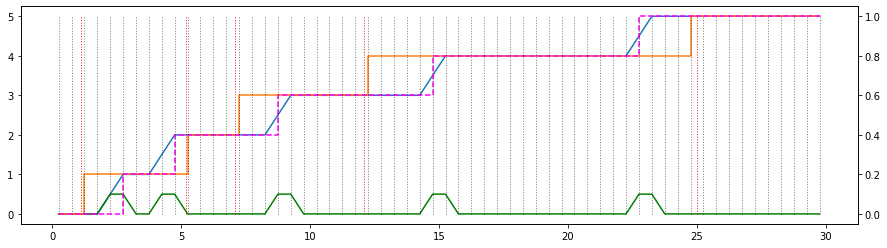

In [103]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

ax1.plot(time, cumsum);
ax1.plot(time, y, color='green');
ax1.step(time, cumstep, where='post');
ax1.step(time, new_cumstep, where='post', linestyle='--', color='magenta');

for t in time:
    ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
for i, event in enumerate(events):
    ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)

plt.show()

In [86]:
np.abs(new_cumstep - cumsum).sum()

12.500000000027775

In [18]:
backtracking

array([[1., 3., 0., 2., 0.],
       [1., 1., 3., 4., 0.],
       [1., 1., 3., 0., 1.],
       [1., 1., 3., 2., 0.],
       [1., 1., 3., 0., 0.]])

In [29]:
np.set_printoptions(precision=4, suppress=True)
distances

array([[     inf,   2.6673,   8.    ,  29.5   , 179.5   ],
       [  0.    ,   4.1673,  10.    ,  32.5   , 179.5   ],
       [  0.0009,   6.0193,  12.    ,  35.5   , 179.5   ],
       [  0.0193,   8.0009,  14.0009,  38.5   , 179.5   ],
       [  0.1673,  10.    ,  16.0193,  41.5   , 179.5   ]])

In [20]:
# np.set_printoptions(formatter={'float': '{:0.4f}'.format})

In [100]:
from scipy.spatial.distance import euclidean, cityblock
from fastdtw import fastdtw

In [101]:
cumstep

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [102]:
cumsum

array([0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. , 1.5, 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2.5, 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. ,
       3. , 3. , 3. , 3.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 4. , 4.5, 5. , 5. , 5. , 5. , 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. ])

In [107]:
distance, warp_path = fastdtw(cumsum, cumstep, dist=euclidean)
warp_path = np.array(warp_path)

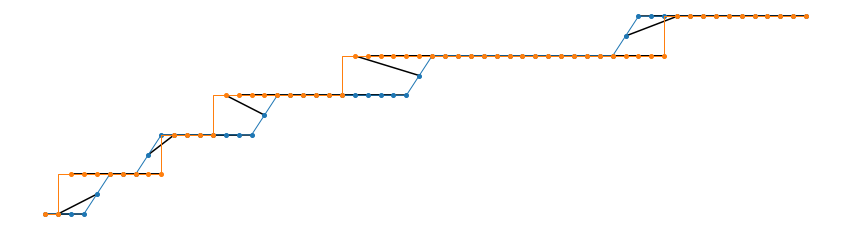

In [108]:
fig, ax = plt.subplots(figsize=(15, 4))

fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [cumsum[map_x], cumstep[map_y]], '-k')
    
ax.plot(cumsum, marker='o', markersize=4, linewidth=1)
ax.step(range(len(cumstep)), cumstep, marker='o', markersize=4, linewidth=1);

In [109]:
warp_path

array([[ 0,  0],
       [ 0,  1],
       [ 1,  1],
       [ 2,  1],
       [ 3,  1],
       [ 4,  1],
       [ 5,  2],
       [ 6,  2],
       [ 6,  3],
       [ 6,  4],
       [ 6,  5],
       [ 6,  6],
       [ 6,  7],
       [ 6,  8],
       [ 6,  9],
       [ 7,  9],
       [ 8, 10],
       [ 9, 11],
       [10, 11],
       [10, 12],
       [10, 13],
       [11, 13],
       [12, 13],
       [13, 13],
       [14, 13],
       [15, 13],
       [16, 13],
       [17, 14],
       [18, 15],
       [19, 15],
       [19, 16],
       [19, 17],
       [19, 18],
       [19, 19],
       [19, 20],
       [19, 21],
       [19, 22],
       [19, 23],
       [20, 23],
       [21, 23],
       [22, 23],
       [23, 23],
       [24, 23],
       [25, 23],
       [26, 23],
       [27, 23],
       [28, 23],
       [29, 24],
       [30, 25],
       [31, 25],
       [31, 26],
       [31, 27],
       [31, 28],
       [31, 29],
       [31, 30],
       [31, 31],
       [31, 32],
       [31, 33],
       [31, 34